In [1]:
# Basic modules
import numpy as np
import pandas as pd
pd.options.display.max_columns=1000
pd.options.display.max_rows=100
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import os

# Import learning modules
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn import linear_model, preprocessing
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance

import xgboost as xgb
from xgboost import XGBRegressor

import nltk

In [2]:
# For EDA - scatter plots of each independent variable to dependent variable
def scatterplots(columns, y_col, data, ncol=None, figsize=(15,8)) :
    if ncol == None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = y_col, data = data, alpha=0.2)
        ax.set(xlabel=col, ylabel=y_col)
    nsubplots = nrow * ncol
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)
        
# For plotting your predictions versus true
def pred_plot(title, y_true, y_pred, figsize=(8,6)):
    sns.set()
    fig, ax = plt.subplots(figsize=(8,6))
    
    ax.scatter(y_true, y_pred, color='b', alpha=0.4, label='predicted')
    ax.plot(y_true, y_true, marker='.', linestyle='-', color='r', label='perfect "model"')

    ax.set_xlabel('true')
    ax.set_ylabel('predicted')
    ax.set_title(title, fontsize=15)
    ax.legend()

    plt.show()
    
# For displaying CV result statistics
def test_stat(model, y_true, y_pred):
    print(model, ": ")
    print("R^2: ", round(r2_score(y_true, y_pred), 4))
    print("RMSE: ", round((mean_squared_error(y_true, y_pred)) ** 0.5, 4))
    print("MAE: ", round(mean_absolute_error(y_true, y_pred), 4))
    
# For plotting residuals
def res_plot(model_name, X, y_true, y_pred, ncol=None, figsize=(15,8)):
    y_res = y_pred - y_true
    if ncol == None:
        ncol = len(X.columns)
    nrow = int(np.ceil(len(X.columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, c in enumerate(X.columns):
        ax = axes.flatten()[i]
        ax.scatter(X[c], y_res, alpha=0.2)
        ax.axhline(0, c='r', linestyle='--')
        ax.set(xlabel=c, ylabel='y residual')
    nsubplots = nrow * ncol
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)
    fig.suptitle(model_name, y=0)
    fig.tight_layout()
    plt.show()

In [3]:
df = pd.read_excel('training_set_rel3.xlsx', sheet_name='training_set')

In [4]:
df.shape

(12978, 28)

In [5]:
df.columns

Index(['essay_id', 'essay_set', 'essay', 'rater1_domain1', 'rater2_domain1',
       'rater3_domain1', 'domain1_score', 'rater1_domain2', 'rater2_domain2',
       'domain2_score', 'rater1_trait1', 'rater1_trait2', 'rater1_trait3',
       'rater1_trait4', 'rater1_trait5', 'rater1_trait6', 'rater2_trait1',
       'rater2_trait2', 'rater2_trait3', 'rater2_trait4', 'rater2_trait5',
       'rater2_trait6', 'rater3_trait1', 'rater3_trait2', 'rater3_trait3',
       'rater3_trait4', 'rater3_trait5', 'rater3_trait6'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12978 entries, 0 to 12977
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   essay_id        12978 non-null  int64  
 1   essay_set       12978 non-null  int64  
 2   essay           12978 non-null  object 
 3   rater1_domain1  12977 non-null  float64
 4   rater2_domain1  12977 non-null  float64
 5   rater3_domain1  128 non-null    float64
 6   domain1_score   12977 non-null  float64
 7   rater1_domain2  1800 non-null   float64
 8   rater2_domain2  1800 non-null   float64
 9   domain2_score   1800 non-null   float64
 10  rater1_trait1   2292 non-null   float64
 11  rater1_trait2   2292 non-null   float64
 12  rater1_trait3   2292 non-null   float64
 13  rater1_trait4   2292 non-null   float64
 14  rater1_trait5   723 non-null    float64
 15  rater1_trait6   723 non-null    float64
 16  rater2_trait1   2292 non-null   float64
 17  rater2_trait2   2292 non-null  

In [7]:
df.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4.0,4.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
temp = {}
for c in df.columns:
    temp[c] = df[c].nunique()
pd.DataFrame(temp.values(), index=temp.keys(), columns=['# unique'])

,# unique
essay_id,12978
essay_set,8
essay,12974
rater1_domain1,30
rater2_domain1,29
rater3_domain1,16
domain1_score,53
rater1_domain2,4
rater2_domain2,4
domain2_score,4


In [9]:
df[df.essay.duplicated()]

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
5149,7549,3,"In the setting of the essay; ""Rough Road Ahead...",1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5290,7690,3,In the essay the features of the setting affec...,2.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6689,10248,4,The author concludes the story with that parag...,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6908,10468,4,The author concluded this paragraph in this st...,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df = df.loc[~df.essay.duplicated(keep='last'), :]

In [11]:
temp = {}
for c in df.columns:
    temp[c] = df[c].nunique()
pd.DataFrame(temp.values(), index=temp.keys(), columns=['# unique'])

,# unique
essay_id,12974
essay_set,8
essay,12974
rater1_domain1,30
rater2_domain1,29
rater3_domain1,16
domain1_score,53
rater1_domain2,4
rater2_domain2,4
domain2_score,4


In [12]:
df.isna().sum()/len(df)

essay_id          0.000000
essay_set         0.000000
essay             0.000000
rater1_domain1    0.000077
rater2_domain1    0.000077
rater3_domain1    0.990134
domain1_score     0.000077
rater1_domain2    0.861261
rater2_domain2    0.861261
domain2_score     0.861261
rater1_trait1     0.823339
rater1_trait2     0.823339
rater1_trait3     0.823339
rater1_trait4     0.823339
rater1_trait5     0.944273
rater1_trait6     0.944273
rater2_trait1     0.823339
rater2_trait2     0.823339
rater2_trait3     0.823339
rater2_trait4     0.823339
rater2_trait5     0.944273
rater2_trait6     0.944273
rater3_trait1     0.990134
rater3_trait2     0.990134
rater3_trait3     0.990134
rater3_trait4     0.990134
rater3_trait5     0.990134
rater3_trait6     0.990134
dtype: float64

In [13]:
df.loc[df.domain1_score.isna() & df.domain2_score.isna(), :]

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
6973,10534,4,"When they come back, Saeng vowed silently to h...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df = df[~(df.domain1_score.isna() & df.domain2_score.isna())]

In [15]:
df.isna().sum()

essay_id              0
essay_set             0
essay                 0
rater1_domain1        0
rater2_domain1        0
rater3_domain1    12845
domain1_score         0
rater1_domain2    11173
rater2_domain2    11173
domain2_score     11173
rater1_trait1     10681
rater1_trait2     10681
rater1_trait3     10681
rater1_trait4     10681
rater1_trait5     12250
rater1_trait6     12250
rater2_trait1     10681
rater2_trait2     10681
rater2_trait3     10681
rater2_trait4     10681
rater2_trait5     12250
rater2_trait6     12250
rater3_trait1     12845
rater3_trait2     12845
rater3_trait3     12845
rater3_trait4     12845
rater3_trait5     12845
rater3_trait6     12845
dtype: int64

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12973 entries, 0 to 12977
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   essay_id        12973 non-null  int64  
 1   essay_set       12973 non-null  int64  
 2   essay           12973 non-null  object 
 3   rater1_domain1  12973 non-null  float64
 4   rater2_domain1  12973 non-null  float64
 5   rater3_domain1  128 non-null    float64
 6   domain1_score   12973 non-null  float64
 7   rater1_domain2  1800 non-null   float64
 8   rater2_domain2  1800 non-null   float64
 9   domain2_score   1800 non-null   float64
 10  rater1_trait1   2292 non-null   float64
 11  rater1_trait2   2292 non-null   float64
 12  rater1_trait3   2292 non-null   float64
 13  rater1_trait4   2292 non-null   float64
 14  rater1_trait5   723 non-null    float64
 15  rater1_trait6   723 non-null    float64
 16  rater2_trait1   2292 non-null   float64
 17  rater2_trait2   2292 non-null  

In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
essay_id,12973.0,10296.026440,6309.677540,1.0,4438.0,10047.0,15682.0,21633.0
essay_set,12973.0,4.179681,2.137109,1.0,2.0,4.0,6.0,8.0
rater1_domain1,12973.0,4.127727,4.212859,0.0,2.0,3.0,4.0,30.0
rater2_domain1,12973.0,4.137825,4.264729,0.0,2.0,3.0,4.0,30.0
rater3_domain1,128.0,37.828125,5.240829,20.0,36.0,40.0,40.0,50.0
domain1_score,12973.0,6.801280,8.971482,0.0,2.0,3.0,8.0,60.0
rater1_domain2,1800.0,3.333889,0.729103,1.0,3.0,3.0,4.0,4.0
rater2_domain2,1800.0,3.330556,0.726807,1.0,3.0,3.0,4.0,4.0
domain2_score,1800.0,3.333889,0.729103,1.0,3.0,3.0,4.0,4.0
rater1_trait1,2292.0,2.444154,1.211730,0.0,2.0,2.0,3.0,6.0


In [18]:
df = df.drop(['essay_id'], axis=1)

<AxesSubplot:>

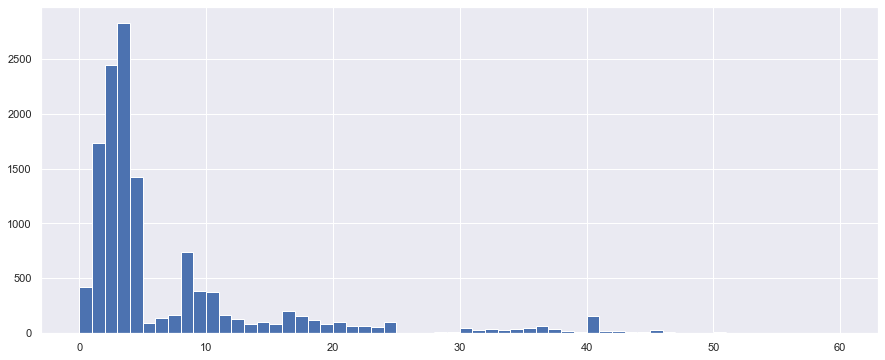

In [19]:
df.domain1_score.hist(bins=list(range(61)), figsize=(15,6))

In [20]:
df.iloc[0].T

essay_set                                                         1
essay             Dear local newspaper, I think effects computer...
rater1_domain1                                                  4.0
rater2_domain1                                                  4.0
rater3_domain1                                                  NaN
domain1_score                                                   8.0
rater1_domain2                                                  NaN
rater2_domain2                                                  NaN
domain2_score                                                   NaN
rater1_trait1                                                   NaN
rater1_trait2                                                   NaN
rater1_trait3                                                   NaN
rater1_trait4                                                   NaN
rater1_trait5                                                   NaN
rater1_trait6                                   

In [21]:
df.iloc[0,1]

"Dear local newspaper, I think effects computers have on people are great learning skills/affects because they give us time to chat with friends/new people, helps us learn about the globe(astronomy) and keeps us out of troble! Thing about! Dont you think so? How would you feel if your teenager is always on the phone with friends! Do you ever time to chat with your friends or buisness partner about things. Well now - there's a new way to chat the computer, theirs plenty of sites on the internet to do so: @ORGANIZATION1, @ORGANIZATION2, @CAPS1, facebook, myspace ect. Just think now while your setting up meeting with your boss on the computer, your teenager is having fun on the phone not rushing to get off cause you want to use it. How did you learn about other countrys/states outside of yours? Well I have by computer/internet, it's a new way to learn about what going on in our time! You might think your child spends a lot of time on the computer, but ask them so question about the econom

In [22]:
df['num_chars'] = 0

for i in range(len(df)):
    df.iloc[i,-1] = len(df.iloc[i,1])

<AxesSubplot:>

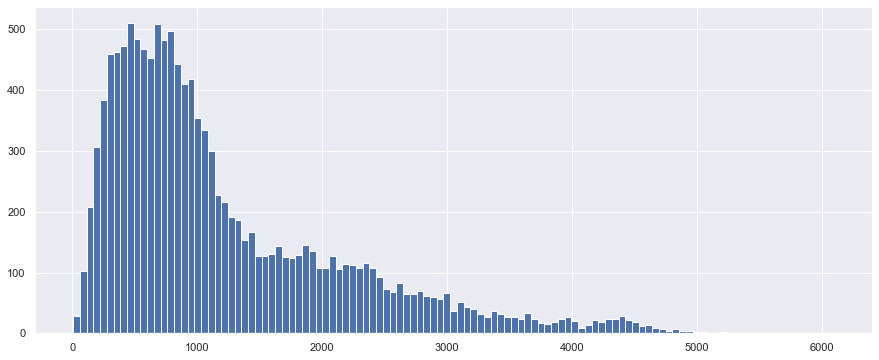

In [23]:
df.num_chars.hist(bins=int(len(df)**0.5), figsize=(15,6))

In [24]:
df['num_words'] = 0

for i in range(len(df)):
    df.iloc[i,-1] = len(df.iloc[i,1].split())

<AxesSubplot:>

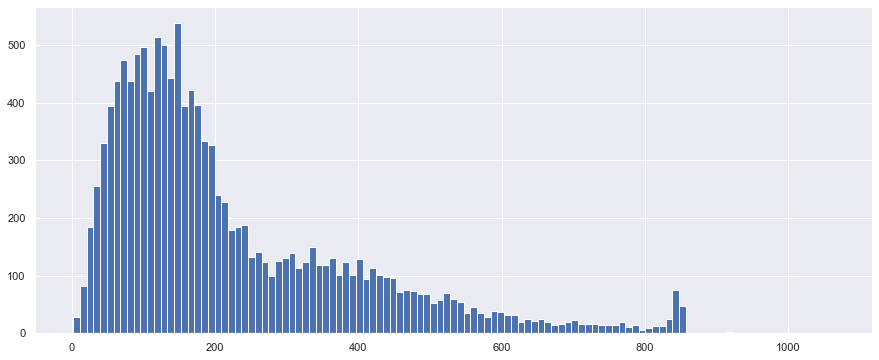

In [25]:
df.num_words.hist(bins=int(len(df)**0.5), figsize=(15,6))

In [26]:
df['avg_word_len'] = df.num_chars / df.num_words

<AxesSubplot:>

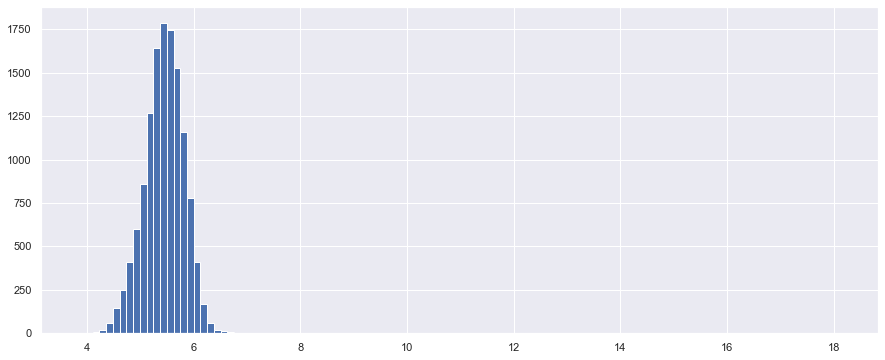

In [27]:
df.avg_word_len.hist(bins=int(len(df)**0.5), figsize=(15,6))

In [28]:
df.avg_word_len.describe()

count    12973.000000
mean         5.446055
std          0.389829
min          3.857143
25%          5.212766
50%          5.459716
75%          5.698113
max         18.120000
Name: avg_word_len, dtype: float64

In [29]:
df.loc[df.avg_word_len == df.avg_word_len.max(), :]

,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6,num_chars,num_words,avg_word_len
2779,2,I do not think that censoship has a ightful pl...,2.0,2.0,NaN,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,906,50,18.12


In [30]:
df.iloc[2779,1]

'I do not think that censoship has a ightful place in our librares. I know that libraries were created to be information! hubs for the public. If censorship were put in place, then many books would be gone as they @MONTH1 be seen as offensive to a  minority of people................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................'

In [31]:
df.iloc[2779,1] = 'I do not think that censoship has a ightful place in our librares. I know that libraries were created to be information! hubs for the public. If censorship were put in place, then many books would be gone as they @MONTH1 be seen as offensive to a  minority of people.'

In [32]:
df.iloc[2779,1]

'I do not think that censoship has a ightful place in our librares. I know that libraries were created to be information! hubs for the public. If censorship were put in place, then many books would be gone as they @MONTH1 be seen as offensive to a  minority of people.'

In [33]:
df.iloc[2779, -3] = len(df.iloc[2779,1])

In [34]:
df.iloc[2779, -2] = len(df.iloc[2779,1].split())

In [35]:
df.iloc[2779, -1] = df.iloc[2779, -3] / df.iloc[2779, -2]

In [36]:
df.iloc[2779,:]

essay_set                                                         2
essay             I do not think that censoship has a ightful pl...
rater1_domain1                                                  2.0
rater2_domain1                                                  2.0
rater3_domain1                                                  NaN
domain1_score                                                   2.0
rater1_domain2                                                  2.0
rater2_domain2                                                  2.0
domain2_score                                                   2.0
rater1_trait1                                                   NaN
rater1_trait2                                                   NaN
rater1_trait3                                                   NaN
rater1_trait4                                                   NaN
rater1_trait5                                                   NaN
rater1_trait6                                   

<AxesSubplot:>

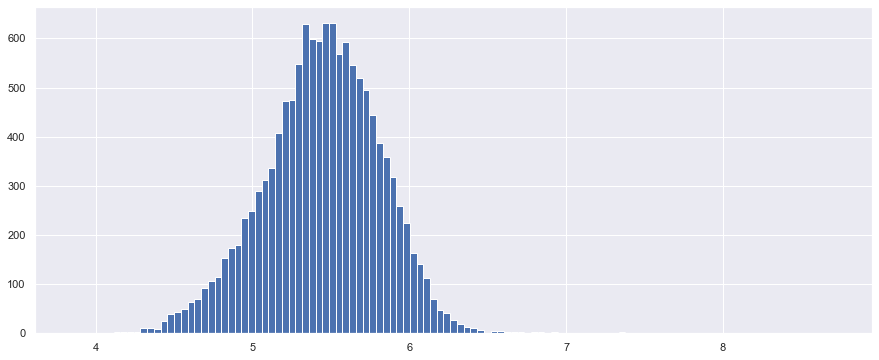

In [37]:
df.avg_word_len.hist(bins=int(len(df)**0.5), figsize=(15,6))

In [38]:
df.loc[df['avg_word_len'] == df['avg_word_len'].max(), :]

,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6,num_chars,num_words,avg_word_len
8739,5,The mood created by the author in this memoir ...,3.0,3.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1524,175,8.708571


In [39]:
df.iloc[8739,1]

'In the memoir, Narciso Rodriguez, the author creates a mood of appreciation + happiness. @CAPS1 does this by starting w/ background, + by the end moving to the lessons @CAPS1 learned from his parents.First, @CAPS1 describes how wounderful this enviornment was in paragraph @NUM1. "My young parents created a traditional Cuban home, the very heart of which was the kitchen... My parents passed on to me... a love of cooking that is still with me today (for which I am eternally grateful). Passionate Cuban music (which I adore to this day) filled the air..." @CAPS1 continues by describing how wonderful a place to grow up it was + how his parents showed him genorosity.Next, @CAPS1 says how hard it was for his parents to leave everything they knew, just for their children. In states in paragraph @NUM2, "they came selflessly... to give their children a better life." @CAPS1 continues by writing of how strong they were by showing him the value of family + friends + genorosity. This shows how appr

In [40]:
df['rater_diff'] = np.abs(df.rater1_domain1 - df.rater2_domain1)

In [41]:
df['nunique_words'] = 0

for i in range(len(df)):
    df.iloc[i,-1] = len(set(df.iloc[i,1].split()))

In [42]:
df['unique_word_frac'] = df.nunique_words / df.num_words

In [43]:
df['num_sents'] = 0

for i in range(len(df)):
    df.iloc[i,-1] = len(nltk.sent_tokenize(df.iloc[i,1]))

In [44]:
df['avg_sent_len'] = df.num_words / df.num_sents

In [45]:
for i in ('!"#$%&' + "'()*+,-./:;<=>?@[\]^_`{|}~"):
    df[str(i) + '_count'] = 0
    for row in range(len(df)):
        df.iloc[row,-1] = df.iloc[row,1].count(i)

In [46]:
"""rater1_series = df_1.rater1_domain1.append(df_2.rater1_domain1).append(df_3.rater1_domain1)\
                        .append(df_4.rater1_domain1).append(df_5.rater1_domain1).append(df_6.rater1_domain1)\
                        .append(df_7.rater1_domain1).append(df_8.rater1_domain1)
rater2_series = df_1.rater2_domain1.append(df_2.rater2_domain1).append(df_3.rater2_domain1)\
                        .append(df_4.rater2_domain1).append(df_5.rater2_domain1).append(df_6.rater2_domain1)\
                        .append(df_7.rater2_domain1).append(df_8.rater2_domain1)
domain1_score_series = df_1.domain1_score.append(df_2.domain1_score).append(df_3.domain1_score)\
                        .append(df_4.domain1_score).append(df_5.domain1_score).append(df_6.domain1_score)\
                        .append(df_7.domain1_score).append(df_8.domain1_score)
domain1_score_series"""

'rater1_series = df_1.rater1_domain1.append(df_2.rater1_domain1).append(df_3.rater1_domain1)                        .append(df_4.rater1_domain1).append(df_5.rater1_domain1).append(df_6.rater1_domain1)                        .append(df_7.rater1_domain1).append(df_8.rater1_domain1)\nrater2_series = df_1.rater2_domain1.append(df_2.rater2_domain1).append(df_3.rater2_domain1)                        .append(df_4.rater2_domain1).append(df_5.rater2_domain1).append(df_6.rater2_domain1)                        .append(df_7.rater2_domain1).append(df_8.rater2_domain1)\ndomain1_score_series = df_1.domain1_score.append(df_2.domain1_score).append(df_3.domain1_score)                        .append(df_4.domain1_score).append(df_5.domain1_score).append(df_6.domain1_score)                        .append(df_7.domain1_score).append(df_8.domain1_score)\ndomain1_score_series'

In [47]:
"""df2.rater1_domain1 = rater1_series
df2.rater2_domain1 = rater2_series
df2.domain1_score = domain1_score_series"""

'df2.rater1_domain1 = rater1_series\ndf2.rater2_domain1 = rater2_series\ndf2.domain1_score = domain1_score_series'

In [48]:
temp = {}
for c in df.columns:
    temp[c] = df[c].nunique()
pd.DataFrame(temp.values(), index=temp.keys(), columns=['# unique'])

,# unique
essay_set,8
essay,12973
rater1_domain1,30
rater2_domain1,29
rater3_domain1,16
domain1_score,53
rater1_domain2,4
rater2_domain2,4
domain2_score,4
rater1_trait1,7


In [49]:
df = df.drop(['#_count', '$_count', '%_count', '*_count', '+_count', ')_count', '<_count', '=_count', '>_count', 
                '[_count', ']_count', '\_count', '^_count', '__count', '{_count', '|_count', '}_count', '~_count'], axis=1)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12973 entries, 0 to 12977
Data columns (total 49 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   essay_set         12973 non-null  int64  
 1   essay             12973 non-null  object 
 2   rater1_domain1    12973 non-null  float64
 3   rater2_domain1    12973 non-null  float64
 4   rater3_domain1    128 non-null    float64
 5   domain1_score     12973 non-null  float64
 6   rater1_domain2    1800 non-null   float64
 7   rater2_domain2    1800 non-null   float64
 8   domain2_score     1800 non-null   float64
 9   rater1_trait1     2292 non-null   float64
 10  rater1_trait2     2292 non-null   float64
 11  rater1_trait3     2292 non-null   float64
 12  rater1_trait4     2292 non-null   float64
 13  rater1_trait5     723 non-null    float64
 14  rater1_trait6     723 non-null    float64
 15  rater2_trait1     2292 non-null   float64
 16  rater2_trait2     2292 non-null   float6

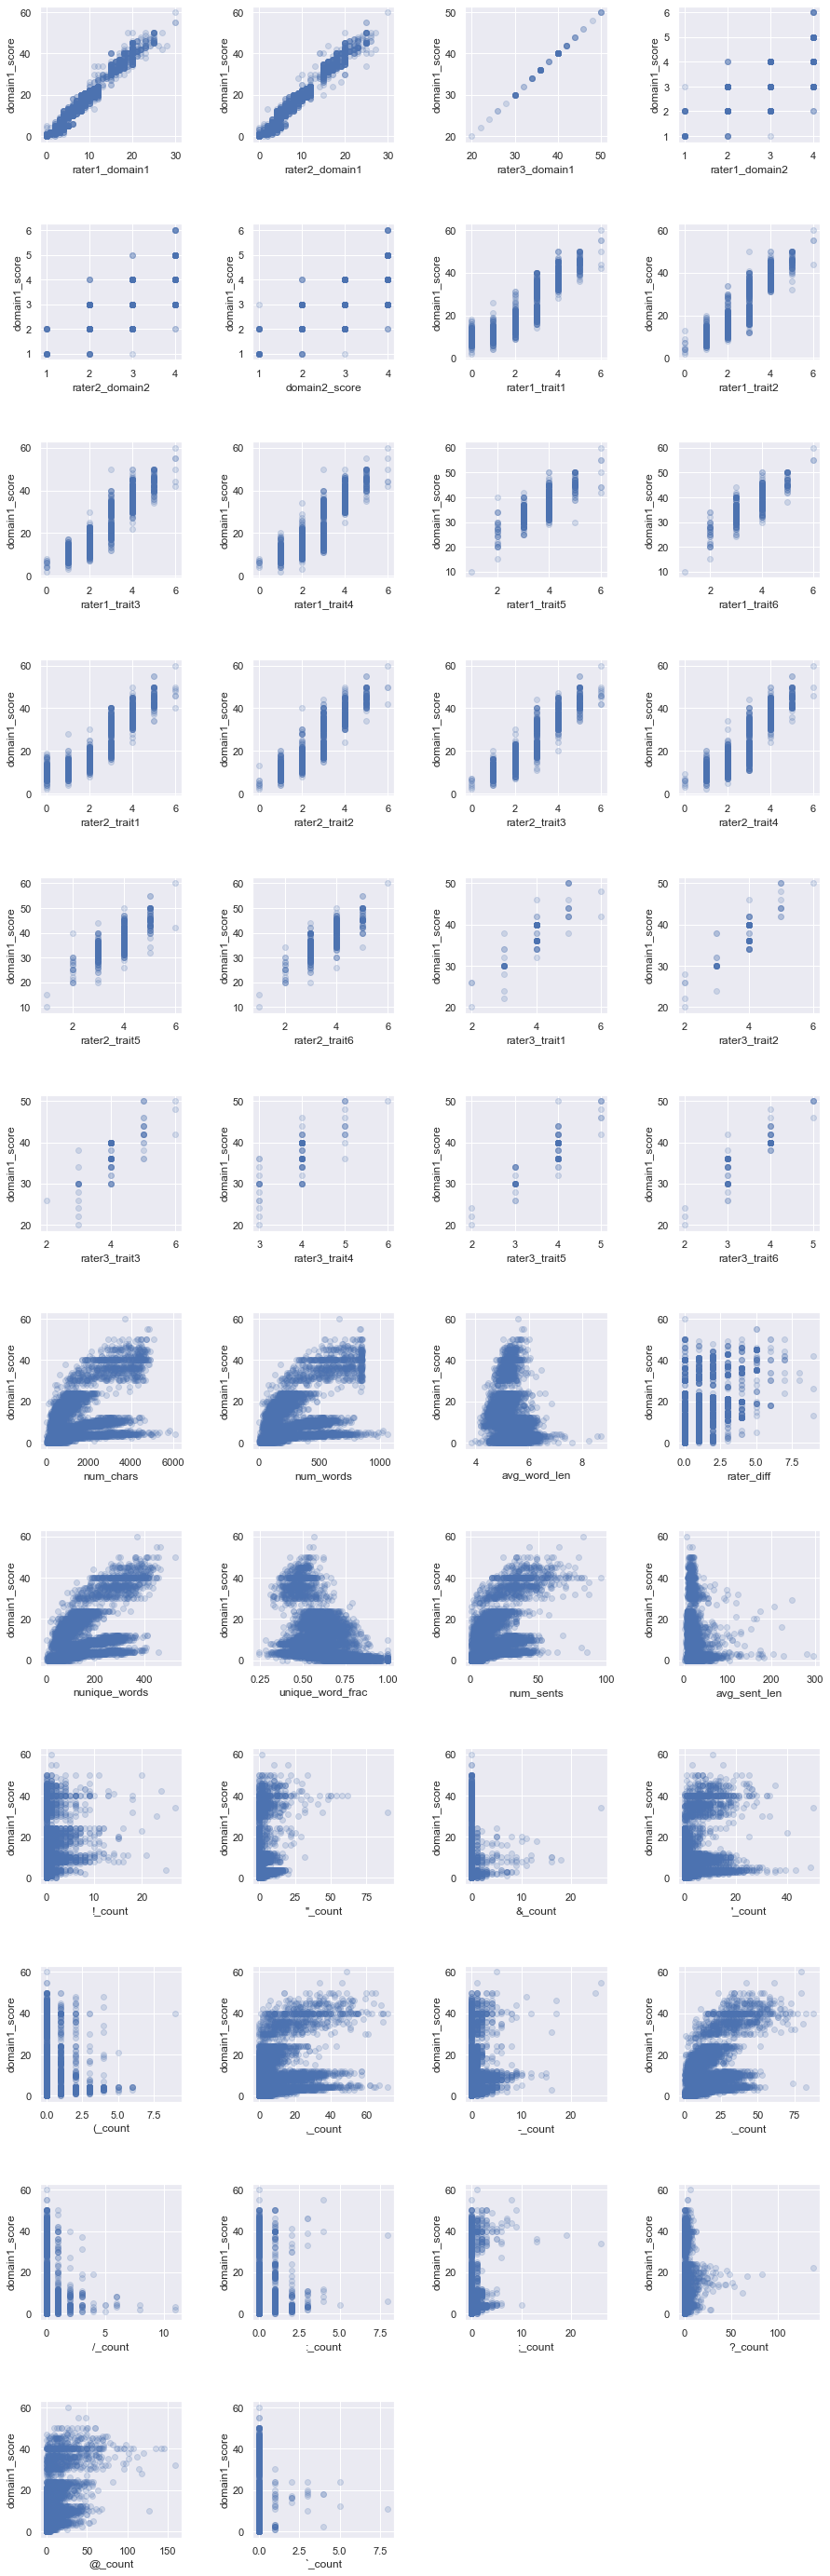

In [51]:
# Quick EDA for feature analysis.
scatterplots(columns = df.drop(['essay_set', 'essay', 'domain1_score'], axis=1).columns, 
             y_col = 'domain1_score', data=df, ncol=4, figsize=(15, 50))

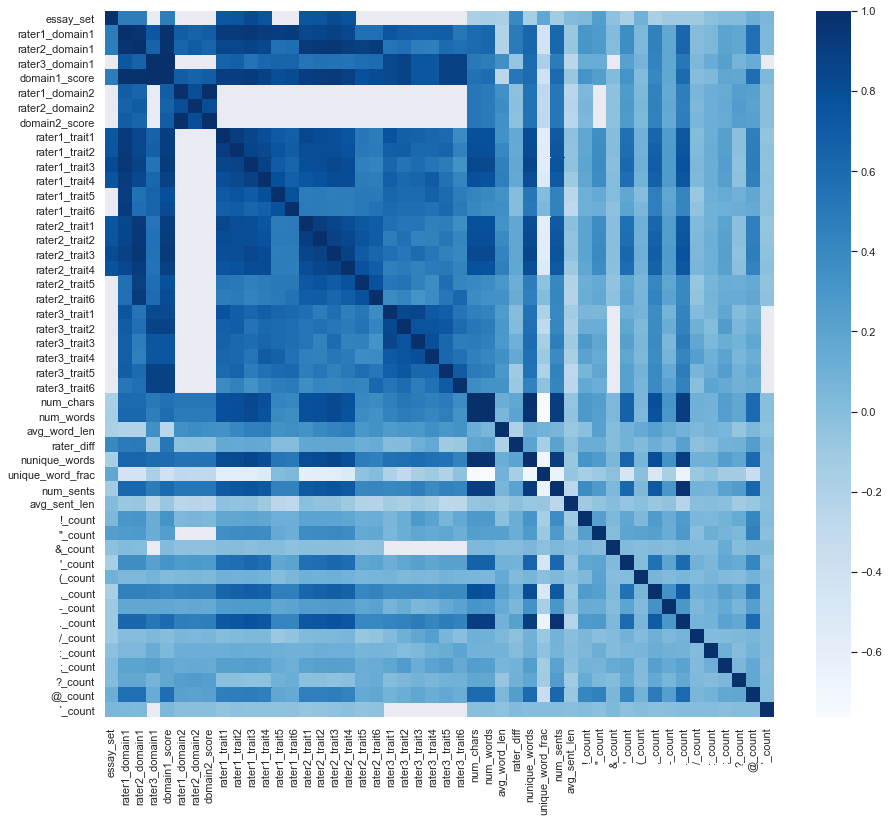

In [52]:
# Also EDA - heatmap
_ = plt.subplots(figsize=(15,13))
_ = sns.heatmap(df.corr(), cmap='Blues')

In [53]:
df = df.drop(['rater3_domain1'], axis=1)

In [54]:
df.isna().sum()

essay_set               0
essay                   0
rater1_domain1          0
rater2_domain1          0
domain1_score           0
rater1_domain2      11173
rater2_domain2      11173
domain2_score       11173
rater1_trait1       10681
rater1_trait2       10681
rater1_trait3       10681
rater1_trait4       10681
rater1_trait5       12250
rater1_trait6       12250
rater2_trait1       10681
rater2_trait2       10681
rater2_trait3       10681
rater2_trait4       10681
rater2_trait5       12250
rater2_trait6       12250
rater3_trait1       12845
rater3_trait2       12845
rater3_trait3       12845
rater3_trait4       12845
rater3_trait5       12845
rater3_trait6       12845
num_chars               0
num_words               0
avg_word_len            0
rater_diff              0
nunique_words           0
unique_word_frac        0
num_sents               0
avg_sent_len            0
!_count                 0
"_count                 0
&_count                 0
'_count                 0
(_count     

In [55]:
df.columns

Index(['essay_set', 'essay', 'rater1_domain1', 'rater2_domain1',
       'domain1_score', 'rater1_domain2', 'rater2_domain2', 'domain2_score',
       'rater1_trait1', 'rater1_trait2', 'rater1_trait3', 'rater1_trait4',
       'rater1_trait5', 'rater1_trait6', 'rater2_trait1', 'rater2_trait2',
       'rater2_trait3', 'rater2_trait4', 'rater2_trait5', 'rater2_trait6',
       'rater3_trait1', 'rater3_trait2', 'rater3_trait3', 'rater3_trait4',
       'rater3_trait5', 'rater3_trait6', 'num_chars', 'num_words',
       'avg_word_len', 'rater_diff', 'nunique_words', 'unique_word_frac',
       'num_sents', 'avg_sent_len', '!_count', '"_count', '&_count', ''_count',
       '(_count', ',_count', '-_count', '._count', '/_count', ':_count',
       ';_count', '?_count', '@_count', '`_count'],
      dtype='object')

In [56]:
cols = ['rater1_domain2', 'rater2_domain2', 'domain2_score',
       'rater1_trait1', 'rater1_trait2', 'rater1_trait3', 'rater1_trait4',
       'rater1_trait5', 'rater1_trait6', 'rater2_trait1', 'rater2_trait2',
       'rater2_trait3', 'rater2_trait4', 'rater2_trait5', 'rater2_trait6',
       'rater3_trait1', 'rater3_trait2', 'rater3_trait3', 'rater3_trait4',
       'rater3_trait5', 'rater3_trait6']

for col in cols:
    df[str(col) + '_isna'] = df[col].isna().astype(int)
    df[col] = df[col].fillna(0)

In [57]:
df.isna().sum()

essay_set              0
essay                  0
rater1_domain1         0
rater2_domain1         0
domain1_score          0
rater1_domain2         0
rater2_domain2         0
domain2_score          0
rater1_trait1          0
rater1_trait2          0
rater1_trait3          0
rater1_trait4          0
rater1_trait5          0
rater1_trait6          0
rater2_trait1          0
rater2_trait2          0
rater2_trait3          0
rater2_trait4          0
rater2_trait5          0
rater2_trait6          0
rater3_trait1          0
rater3_trait2          0
rater3_trait3          0
rater3_trait4          0
rater3_trait5          0
rater3_trait6          0
num_chars              0
num_words              0
avg_word_len           0
rater_diff             0
nunique_words          0
unique_word_frac       0
num_sents              0
avg_sent_len           0
!_count                0
"_count                0
&_count                0
'_count                0
(_count                0
,_count                0


In [58]:
X = df.drop(['essay', 'rater1_domain1', 'rater2_domain1', 'domain1_score'], axis=1)
y = df.domain1_score

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9729, 65) (3244, 65) (9729,) (3244,)


In [60]:
rf = RandomForestRegressor(n_estimators=1000, max_features=28, random_state=42, n_jobs=-1)

In [61]:
cv_score = cross_val_score(rf, X_train, y_train, cv=5)
print(cv_score, cv_score.mean(), cv_score.std())

[0.99542354 0.99542873 0.99475478 0.99568403 0.99560989] 0.99538019491764 0.0003287714529908957


In [62]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_features=28, n_estimators=1000, n_jobs=-1,
                      random_state=42)

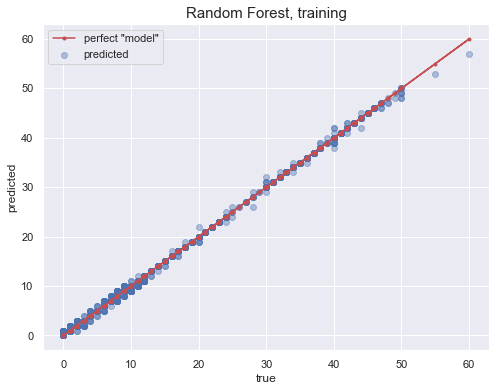

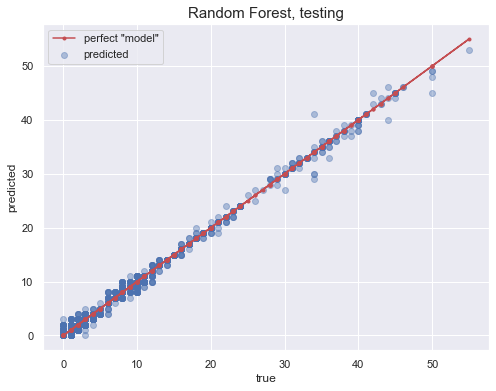

In [63]:
# Predict Testing and Test sets using Lasso regression
y_tr_rf_pred = rf.predict(X_train)
y_te_rf_pred = rf.predict(X_test)

# Plot predicted vs true
pred_plot("Random Forest, training", y_train, np.round(y_tr_rf_pred))
pred_plot("Random Forest, testing", y_test, np.round(y_te_rf_pred))

In [64]:
# Print test stats
test_stat("Random Forest", y_train, y_tr_rf_pred)

Random Forest : 
R^2:  0.9994
RMSE:  0.221
MAE:  0.1498


In [65]:
# Print test stats
test_stat("Random Forest", y_test, y_te_rf_pred)

Random Forest : 
R^2:  0.9954
RMSE:  0.5981
MAE:  0.4027


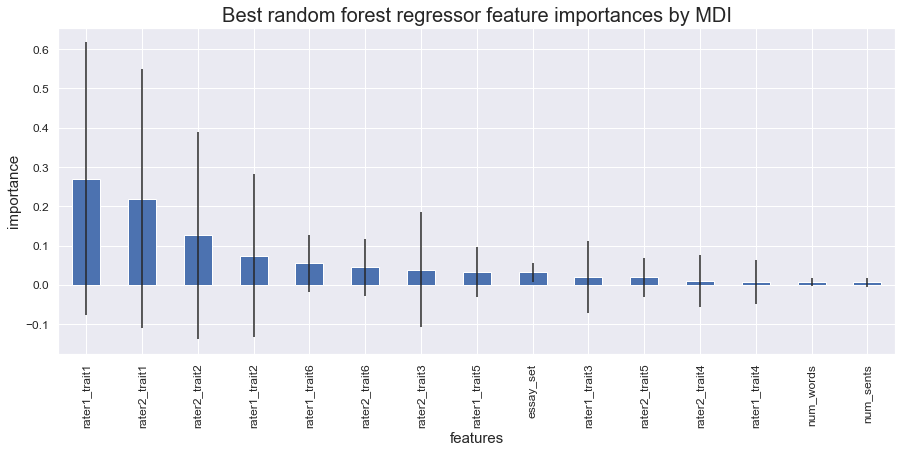

In [66]:
# Plot the feature importances.
plt.subplots(figsize=(15, 6))
imps = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
rf_feat_imps = pd.DataFrame(np.array([imps, std]).T, index=X_train.columns, columns=['importance', 'std'])\
                    .sort_values(by='importance', ascending=False)[:15]
_ = rf_feat_imps['importance'].plot(kind='bar', yerr=rf_feat_imps['std'], fontsize=12)
_ = plt.xlabel('features', fontsize=15)
_ = plt.ylabel('importance', fontsize=15)
_ = plt.title('Best random forest regressor feature importances by MDI', fontsize=20);
plt.show()

In [67]:
result = permutation_importance(rf, X_test, y_test, random_state=42, n_jobs=-1)

In [68]:
forest_importances = pd.DataFrame(np.array([result.importances_mean, result.importances_std]).T, 
                                  index=X_train.columns, columns=['importance', 'std'])\
                            .sort_values(by='importance', ascending=False)[:15]

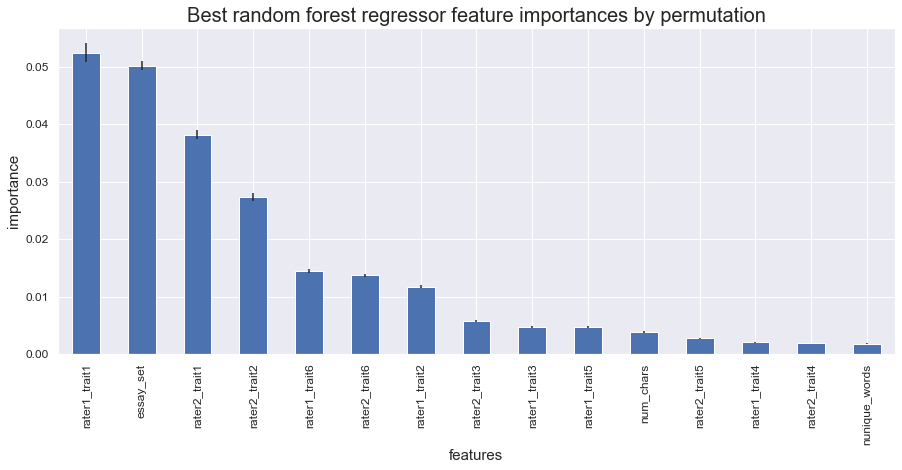

In [69]:
plt.subplots(figsize=(15, 6))
_ = forest_importances['importance'].plot(kind='bar', yerr=forest_importances['std'], fontsize=12)
_ = plt.xlabel('features', fontsize=15)
_ = plt.ylabel('importance', fontsize=15)
_ = plt.title('Best random forest regressor feature importances by permutation', fontsize=20);
plt.show()

In [70]:
xgb.set_config(verbosity=0)

In [71]:
xg = XGBRegressor(alpha=10, min_child_weight=10, n_estimators=100, max_depth=6, num_boost_round=50, gamma=0.1, seed=42)

In [72]:
cv_score = cross_val_score(xg, X_train, y_train, cv=5)
print(cv_score, cv_score.mean(), cv_score.std())

[0.99538462 0.99567054 0.99508469 0.99588638 0.99595741] 0.9955967291617227 0.00032453348490469453


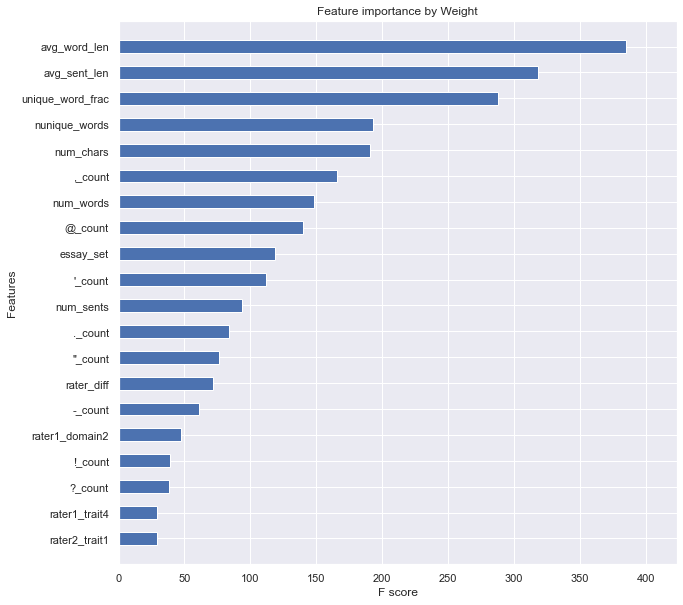

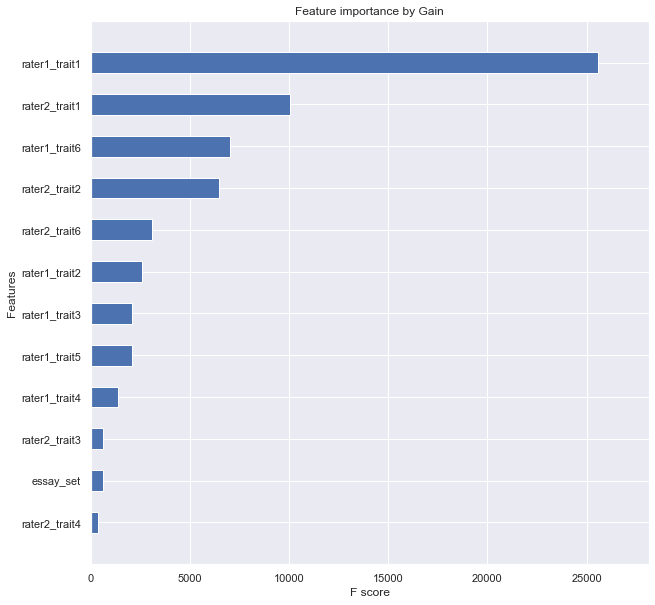

In [73]:
xg.fit(X_train, y_train)

# Plot top 20 feature importances of XG Boost model. Importance type 'weight' and 'gain' show completely different results. Plot both
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(xg, importance_type = 'weight', ax=ax, title='Feature importance by Weight', 
                    height=0.5, max_num_features=20, show_values=False)
plt.show()

fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(xg, importance_type = 'gain', ax=ax, title='Feature importance by Gain', 
                    height=0.5, max_num_features=12, show_values=False)
plt.show()

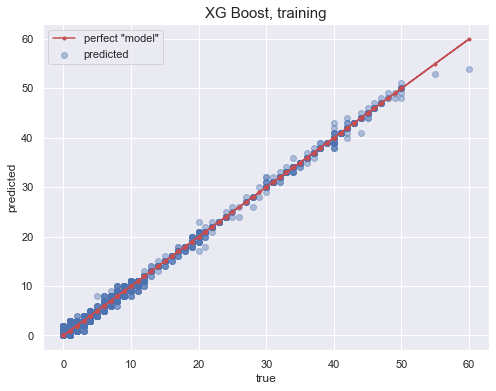

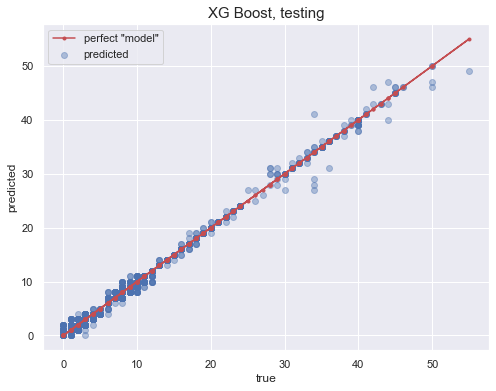

In [74]:
# Predict on Training and Test sets using XG Boost model
y_tr_xg_pred = xg.predict(X_train)
y_te_xg_pred = xg.predict(X_test)

# Plot predicted vs true
pred_plot("XG Boost, training", y_train, np.round(y_tr_xg_pred))
pred_plot("XG Boost, testing", y_test, np.round(y_te_xg_pred))

In [75]:
# Print test stats
test_stat("XG Boost", y_train, y_tr_xg_pred)

XG Boost : 
R^2:  0.9974
RMSE:  0.4571
MAE:  0.332


In [76]:
# Print test stats
test_stat("XG Boost", y_test, y_te_xg_pred)

XG Boost : 
R^2:  0.995
RMSE:  0.6201
MAE:  0.4163


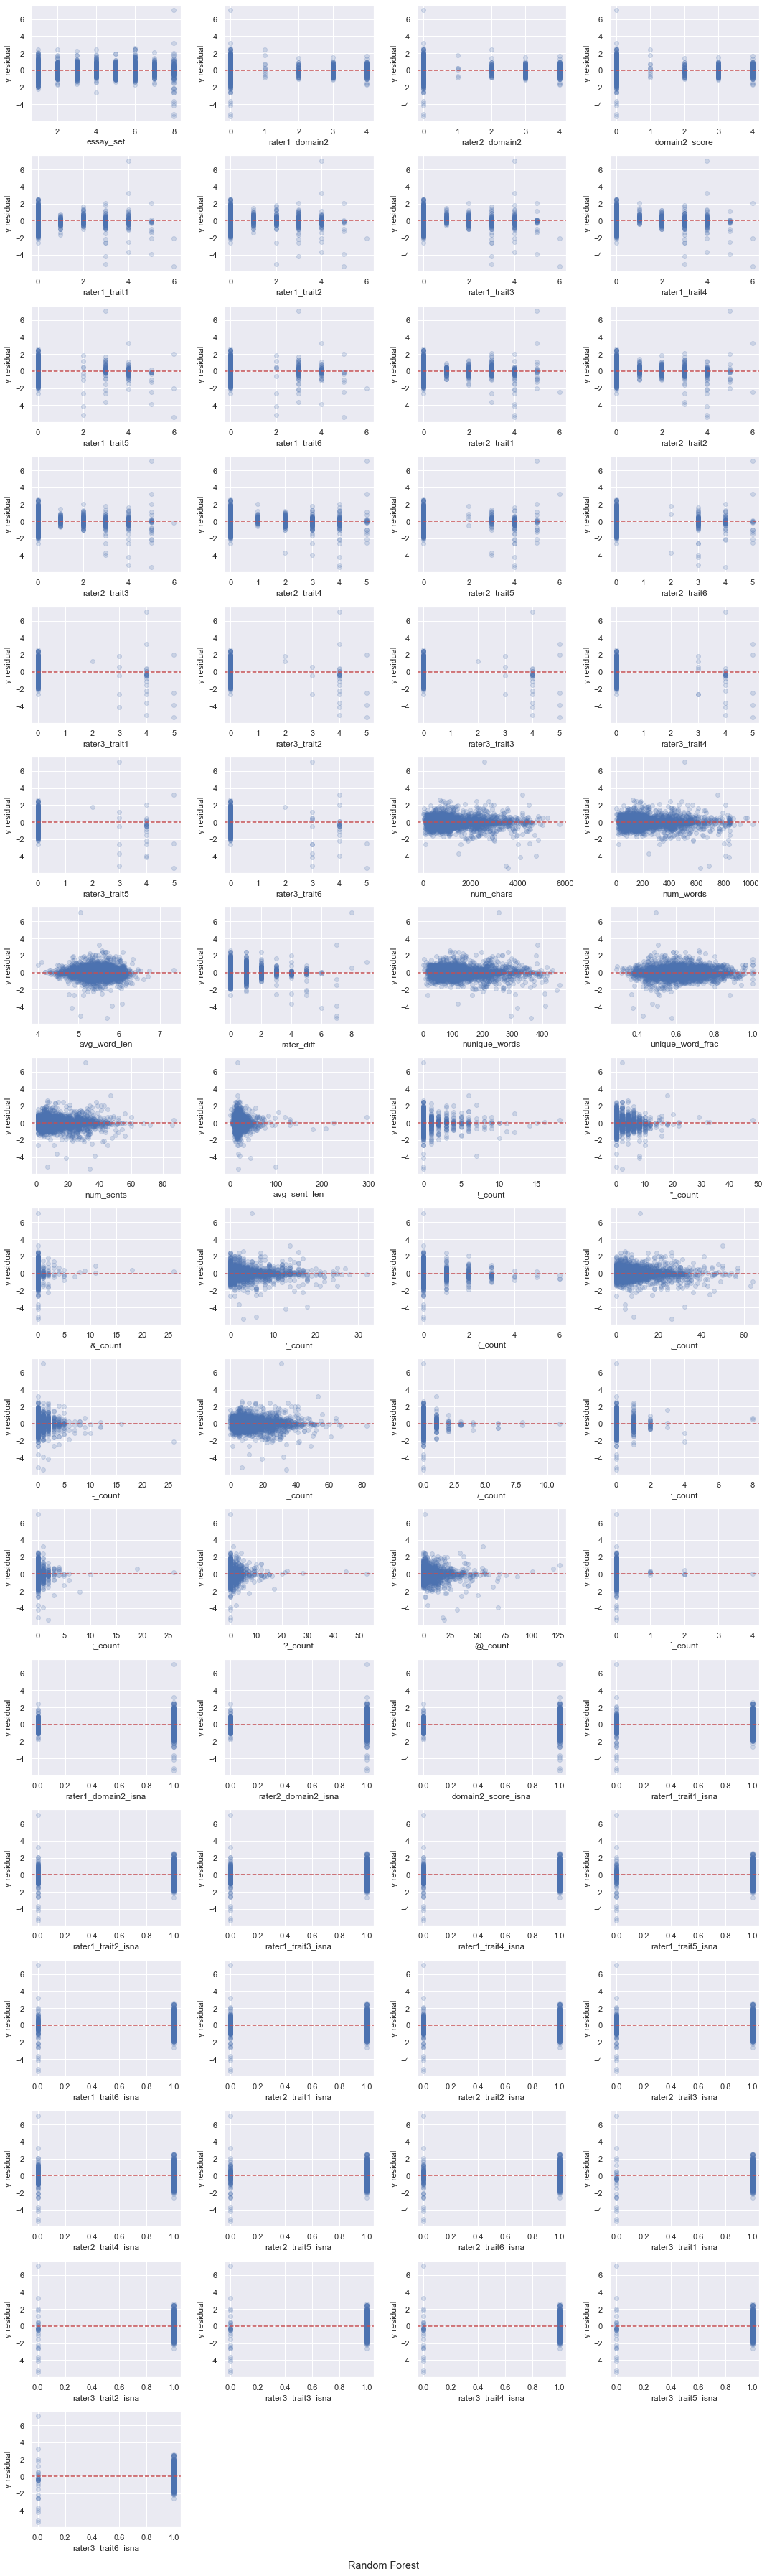

In [77]:
# Random Forest Testing prediction residuals
res_plot('Random Forest', X_test, y_test, y_te_rf_pred, ncol=4, figsize=(15,50))

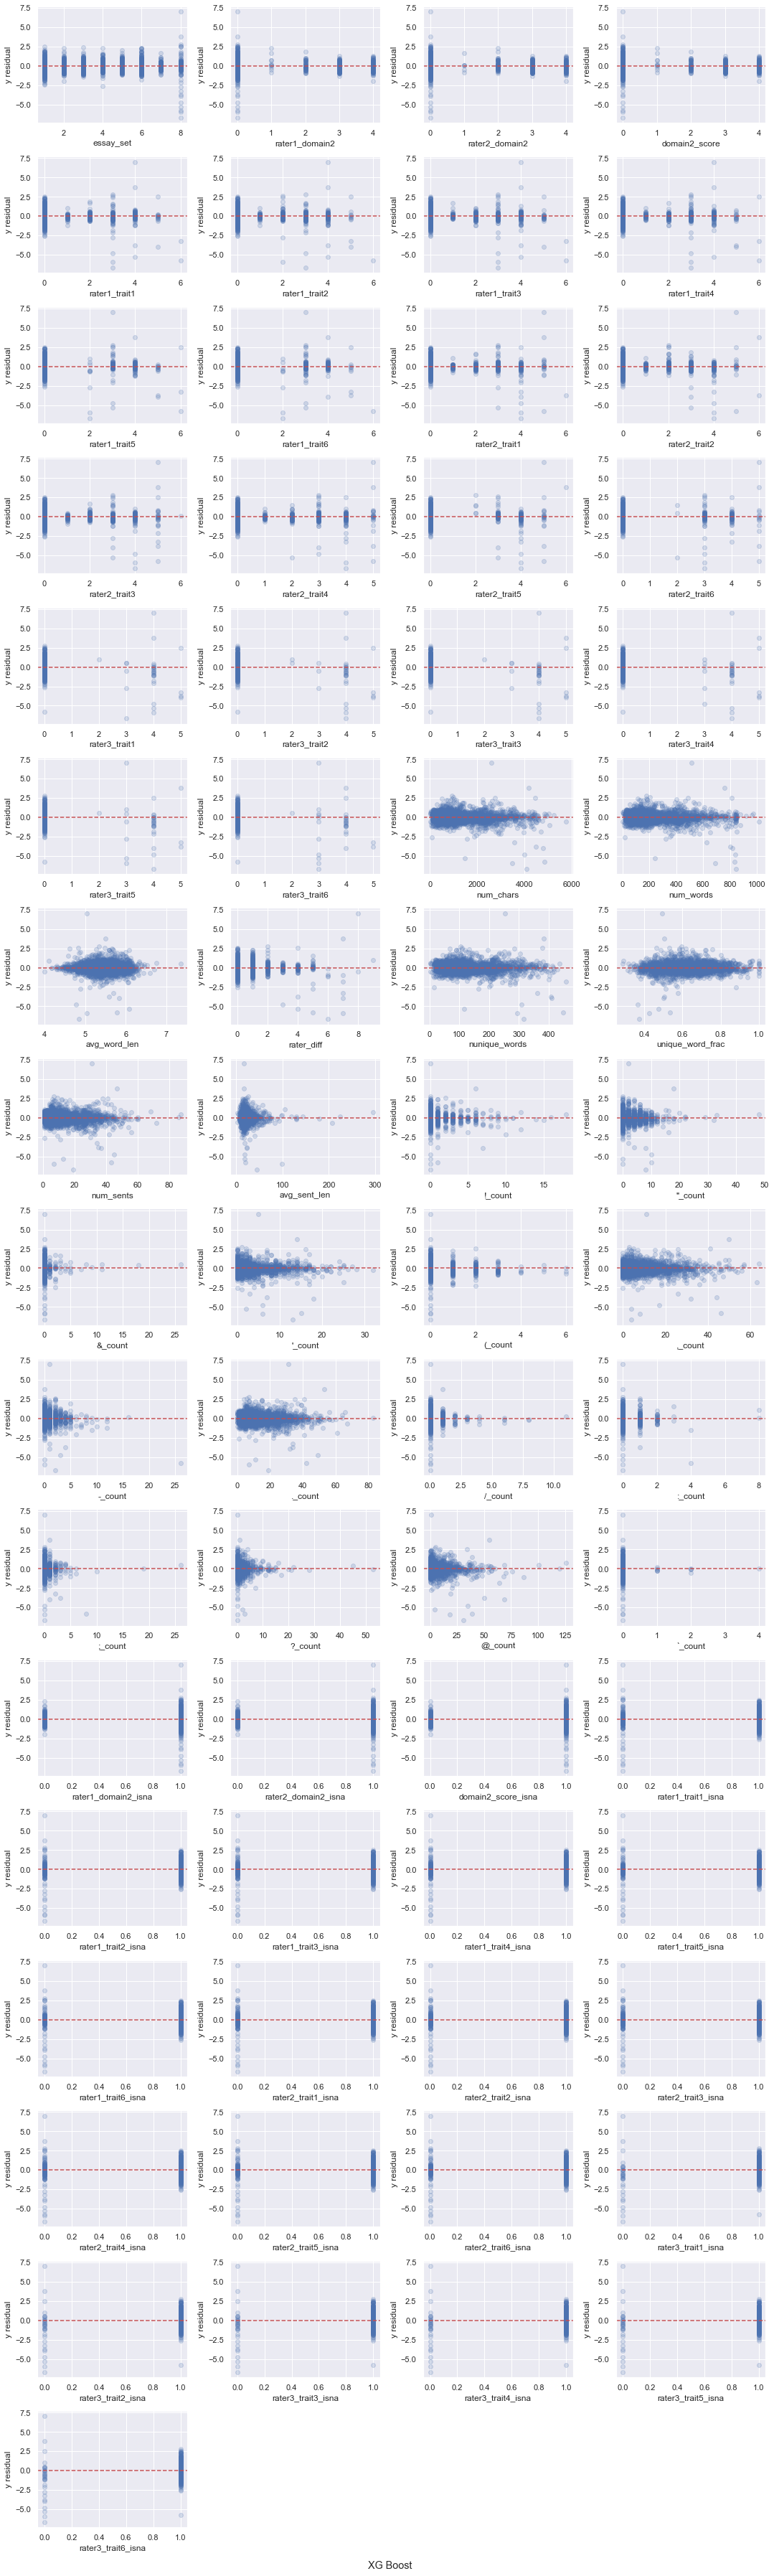

In [78]:
# XG Boost Testing prediction residuals
res_plot('XG Boost', X_test, y_test, y_te_xg_pred, ncol=4, figsize=(15,50))

In [79]:
ptrans = PowerTransformer()
scaler = StandardScaler()
lasso = Lasso(random_state=42)

pipe1 = make_pipeline(ptrans, lasso)
pipe2 = make_pipeline(scaler, lasso)

In [80]:
pipe1.get_params()

{'memory': None,
 'steps': [('powertransformer', PowerTransformer()),
  ('lasso', Lasso(random_state=42))],
 'verbose': False,
 'powertransformer': PowerTransformer(),
 'lasso': Lasso(random_state=42),
 'powertransformer__copy': True,
 'powertransformer__method': 'yeo-johnson',
 'powertransformer__standardize': True,
 'lasso__alpha': 1.0,
 'lasso__copy_X': True,
 'lasso__fit_intercept': True,
 'lasso__max_iter': 1000,
 'lasso__normalize': False,
 'lasso__positive': False,
 'lasso__precompute': False,
 'lasso__random_state': 42,
 'lasso__selection': 'cyclic',
 'lasso__tol': 0.0001,
 'lasso__warm_start': False}

In [81]:
# Parameter grid for pipeline - scaler is optional.
params = {
    'powertransformer': [None, PowerTransformer()],
    'lasso__alpha': [n for n in np.logspace(-6,0,13)],
    'lasso__max_iter': [1000, 10000]
}

# 3-fold CV Grid Search, fit, and print CV test results for top five estimators. Commented out for run-through
lasso_grid_cv = GridSearchCV(pipe1, params, cv=3, n_jobs=-1)
lasso_grid_cv.fit(X_train, y_train)
print(lasso_grid_cv.best_params_)
pd.DataFrame(lasso_grid_cv.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

{'lasso__alpha': 0.001, 'lasso__max_iter': 1000, 'powertransformer': None}


C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5749.888705683197, tolerance: 79.35644343714668
  model = cd_fast.enet_coordinate_descent(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lasso__alpha,param_lasso__max_iter,param_powertransformer,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
24,2.953322,0.162876,0.011682,0.002091,0.001,1000,None,"{'lasso__alpha': 0.001, 'lasso__max_iter': 100...",0.986710,0.984230,0.986108,0.985683,0.001056,1
26,17.603155,0.574689,0.017287,0.004018,0.001,10000,None,"{'lasso__alpha': 0.001, 'lasso__max_iter': 100...",0.986698,0.984226,0.986116,0.985680,0.001055,2
22,18.026519,0.842376,0.016377,0.001865,0.000316,10000,None,"{'lasso__alpha': 0.00031622776601683794, 'lass...",0.986724,0.984157,0.986113,0.985665,0.001095,3
20,3.057566,0.085695,0.020172,0.008040,0.000316,1000,None,"{'lasso__alpha': 0.00031622776601683794, 'lass...",0.986727,0.984158,0.986105,0.985664,0.001095,4
16,2.418444,0.019021,0.015624,0.002488,0.0001,1000,None,"{'lasso__alpha': 0.0001, 'lasso__max_iter': 10...",0.986671,0.984128,0.986103,0.985634,0.001090,5


In [82]:
# Parameter grid for pipeline - scaler is optional.
params = {
    'standardscaler': [None, StandardScaler()],
    'lasso__alpha': [n for n in np.logspace(-6,0,13)],
    'lasso__max_iter': [1000, 10000]
}

# 3-fold CV Grid Search, fit, and print CV test results for top five estimators. Commented out for run-through
lasso_grid_cv = GridSearchCV(pipe2, params, cv=3, n_jobs=-1)
lasso_grid_cv.fit(X_train, y_train)
print(lasso_grid_cv.best_params_)
pd.DataFrame(lasso_grid_cv.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

{'lasso__alpha': 0.001, 'lasso__max_iter': 1000, 'standardscaler': None}


C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5749.888705683197, tolerance: 79.35644343714668
  model = cd_fast.enet_coordinate_descent(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lasso__alpha,param_lasso__max_iter,param_standardscaler,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
24,3.140335,0.317828,0.014505,0.004459,0.001,1000,None,"{'lasso__alpha': 0.001, 'lasso__max_iter': 100...",0.986710,0.984230,0.986108,0.985683,0.001056,1
26,19.260013,1.658128,0.017003,0.002843,0.001,10000,None,"{'lasso__alpha': 0.001, 'lasso__max_iter': 100...",0.986698,0.984226,0.986116,0.985680,0.001055,2
22,21.516156,1.460841,0.016628,0.002614,0.000316,10000,None,"{'lasso__alpha': 0.00031622776601683794, 'lass...",0.986724,0.984157,0.986113,0.985665,0.001095,3
20,3.265967,0.279063,0.014632,0.002490,0.000316,1000,None,"{'lasso__alpha': 0.00031622776601683794, 'lass...",0.986727,0.984158,0.986105,0.985664,0.001095,4
27,3.993333,0.172576,0.029759,0.007193,0.001,10000,StandardScaler(),"{'lasso__alpha': 0.001, 'lasso__max_iter': 100...",0.986657,0.984208,0.986052,0.985639,0.001041,5


In [83]:
lasso_best = Lasso(alpha=0.001, max_iter=1000)
lasso_best.fit(X_train, y_train)

C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5749.888705683197, tolerance: 79.35644343714668
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.001)

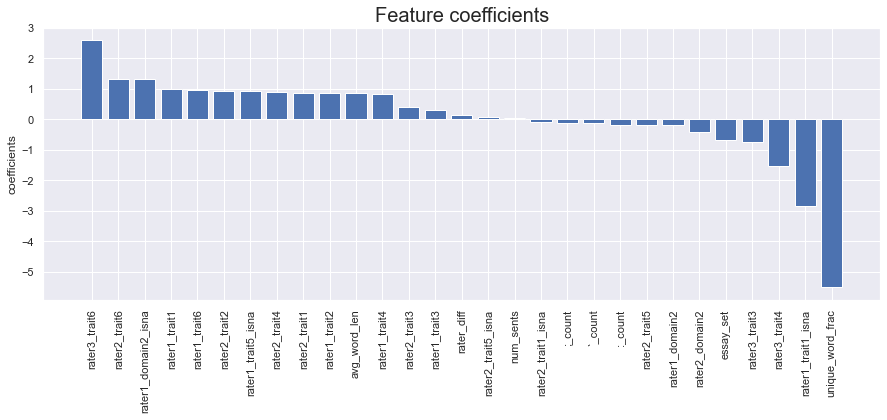

In [84]:
# For plotting purposes - keep only the coefficients of absolute value > 0.2 to keep the plot visually comprehensible
lasso_coefs = pd.DataFrame(lasso_best.coef_, index=X_train.columns, columns=['coef'])
lasso_coefs = lasso_coefs[abs(lasso_coefs.coef) > 0.05].sort_values(by='coef', ascending=False)

# Plot feature coefficients of Lasso regression
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(lasso_coefs.index, lasso_coefs.coef)
plt.xticks(rotation='vertical')
plt.ylabel('coefficients')
plt.title('Feature coefficients', fontsize=20)
plt.show()

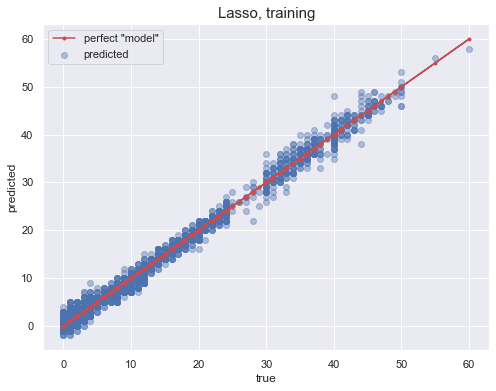

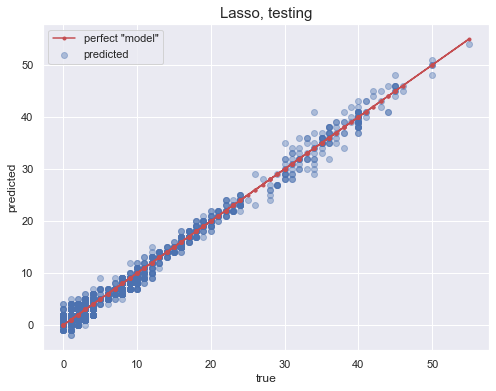

In [85]:
# Predict Testing and Test sets using Lasso regression
y_tr_lasso_pred = lasso_best.predict(X_train)
y_te_lasso_pred = lasso_best.predict(X_test)

# Plot predicted vs true
pred_plot("Lasso, training", y_train, np.round(y_tr_lasso_pred))
pred_plot("Lasso, testing", y_test, np.round(y_te_lasso_pred))

In [86]:
# Print test stats for Lasso
test_stat("Lasso", y_train, y_tr_lasso_pred)

Lasso : 
R^2:  0.9861
RMSE:  1.0637
MAE:  0.8434


In [87]:
# Print test stats for Lasso
test_stat("Lasso", y_test, y_te_lasso_pred)

Lasso : 
R^2:  0.9849
RMSE:  1.0798
MAE:  0.8585


In [88]:
quadratic = PolynomialFeatures(2)

quadreg = make_pipeline(quadratic, lasso)

In [89]:
quadreg.fit(X_train, y_train)

C:\Users\jaeyo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11380.728508197146, tolerance: 79.35644343714668
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('lasso', Lasso(random_state=42))])

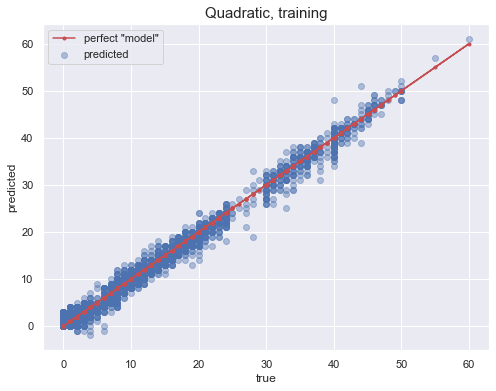

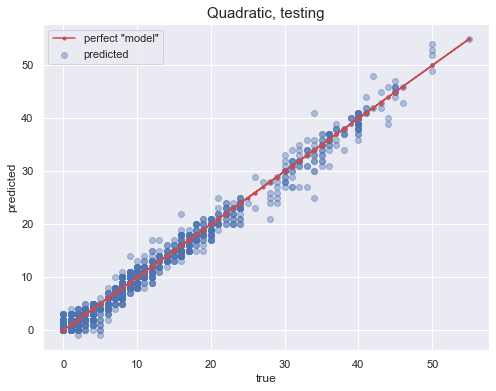

In [90]:
# Predict Testing and Test sets using Lasso regression
y_tr_quad_pred = quadreg.predict(X_train)
y_te_quad_pred = quadreg.predict(X_test)

# Plot predicted vs true
pred_plot("Quadratic, training", y_train, np.round(y_tr_quad_pred))
pred_plot("Quadratic, testing", y_test, np.round(y_te_quad_pred))

In [91]:
# Print test stats for Lasso
test_stat("Quadratic", y_train, y_tr_quad_pred)

Quadratic : 
R^2:  0.9875
RMSE:  1.0088
MAE:  0.7331


In [92]:
# Print test stats for Lasso
test_stat("Quadratic", y_test, y_te_quad_pred)

Quadratic : 
R^2:  0.9856
RMSE:  1.0543
MAE:  0.7379
